In [2]:
period=-4800
time_interval='1d'
tickers = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X']
forex_tickers = ['EURUSD', 'GBPUSD', 'USDCHF', 'USDJPY']

%run forex_data_loader.ipynb

yfinance version: 0.2.50
Start load FOREX data interval with: 1d, from: 2011-10-11 17:51:51.852905


[*********************100%***********************]  4 of 4 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3426 entries, 2011-10-11 to 2024-12-01
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (EURUSD=X, Adj Close)  3424 non-null   float64
 1   (GBPUSD=X, Adj Close)  3425 non-null   float64
 2   (USDCHF=X, Adj Close)  3422 non-null   float64
 3   (USDJPY=X, Adj Close)  3426 non-null   float64
 4   (EURUSD=X, Close)      3424 non-null   float64
 5   (GBPUSD=X, Close)      3425 non-null   float64
 6   (USDCHF=X, Close)      3422 non-null   float64
 7   (USDJPY=X, Close)      3426 non-null   float64
 8   (EURUSD=X, High)       3424 non-null   float64
 9   (GBPUSD=X, High)       3425 non-null   float64
 10  (USDCHF=X, High)       3422 non-null   float64
 11  (USDJPY=X, High)       3426 non-null   float64
 12  (EURUSD=X, Low)        3424 non-null   float64
 13  (GBPUSD=X, Low)        3425 non-null   float64
 14  (USDCHF=X, Low)        3422 non-null  

In [3]:
import os
import pandas as pd
import talib as ta
from talib import MA_Type
import warnings
from tqdm import tqdm
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import backtesting
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter('ignore')
tqdm.pandas()

In [4]:
%run file_loader.ipynb
%run useful_functions.ipynb

In [ ]:
dir = "forex_data"
forex_dict = {}
for name in forex_tickers:
    f = os.path.join(dir, name+'.csv')
    if os.path.isfile(f):
        df = loading_v3(f)
        df = df.dropna()

        df = add_signal_2(df)
        df = add_pointpos_column(df, "Signal", 1e-4) # ???

        df = df.sort_values('Date').reset_index(drop=True)
        df = df.set_index('Date')

        forex_dict[name] = df


  0%|          | 0/3424 [00:00<?, ?it/s]

100%|██████████| 3426/3426 [00:00<00:00, 4709.17it/s]


In [9]:
forex_dict['EURUSD'].describe()

,Close,High,Low,Open,Volume,chg,vol_chg,Signal,pointpos
count,3424.000000,3424.000000,3424.000000,3424.000000,3424.0,3424.000000,3424.0,3424.000000,33.000000
mean,1.168054,1.171733,1.164097,1.168039,0.0,-0.006224,0.0,0.014311,1.189224
std,0.098574,0.098657,0.098670,0.098575,0.0,0.501617,0.0,0.153162,0.090199
min,0.959619,0.967006,0.760572,0.959619,0.0,-2.780000,0.0,0.000000,1.063130
25%,1.093234,1.096428,1.089770,1.093216,0.0,-0.290000,0.0,0.000000,1.111335
50%,1.134224,1.137735,1.130771,1.134083,0.0,0.000000,0.0,0.000000,1.171856
75%,1.230398,1.234568,1.226290,1.230270,0.0,0.280000,0.0,0.000000,1.262510
max,1.417394,1.420091,1.413927,1.417495,0.0,3.180000,0.0,2.000000,1.385080


In [10]:
sum([forex_dict[key]['Signal'].value_counts() for key in forex_dict], start=0)

Signal
0    13530
1       84
2       83
Name: count, dtype: int64

In [11]:
for df in forex_dict.values():
    print(len(df[df.Signal != 0]))

33
46
39
49


In [22]:
plot_candlestick_with_signals(forex_dict['EURUSD'], start_index=3300, num_rows=100)

In [24]:
%run backtest_strategy.ipynb

In [25]:
results = dict()

for name, df in forex_dict.items():
    bt = Backtest(df, StopLossStrategy, cash=10000, margin=1/10, commission=0.002)
    results[name] = bt.run()

In [26]:
for name, stats in results.items():
    print("=== Stats of {} ===".format(name))
    print(stats)

=== Stats of EURUSD ===
Start                     2011-10-11 00:00:00
End                       2024-11-29 00:00:00
Duration                   4798 days 00:00:00
Exposure Time [%]                   10.338785
Equity Final [$]                  8457.876582
Equity Peak [$]                  10085.087078
Return [%]                         -15.421234
Buy & Hold Return [%]              -22.533006
Return (Ann.) [%]                   -1.225106
Volatility (Ann.) [%]                2.109607
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -16.134818
Avg. Drawdown [%]                   -5.671567
Max. Drawdown Duration     4599 days 00:00:00
Avg. Drawdown Duration     1551 days 00:00:00
# Trades                                   31
Win Rate [%]                         45.16129
Best Trade [%]                       2.057982
Worst Trade [%]                     -3.615092
Avg. Trade

In [27]:
for name, stats in results.items():
    print("=== Return of {}, {} ===".format(name, stats["Return [%]"]))


=== Return of EURUSD, -15.42123417675717 ===
=== Return of GBPUSD, -1.8521368973039354 ===
=== Return of USDCHF, -10.756902657495667 ===
=== Return of USDJPY, -9.995478405761624 ===


In [30]:
for name, stats in results.items():
    print("=== Win Rate of {}, {} ===".format(name, stats["Win Rate [%]"]))

=== Win Rate of EURUSD, 45.16129032258064 ===
=== Win Rate of GBPUSD, 62.22222222222222 ===
=== Win Rate of USDCHF, 50.0 ===
=== Win Rate of USDJPY, 32.6530612244898 ===


In [28]:
equity_curves = [stats['_equity_curve']['Equity'] for stats in results.values()]
max_length = max(len(equity) for equity in equity_curves)

# Pad each equity curve with the last value to match the maximum length
padded_equity_curves = []
for equity in equity_curves:
    last_value = equity.iloc[-1]
    padding = [last_value] * (max_length - len(equity))
    padded_equity = equity.tolist() + padding
    padded_equity_curves.append(padded_equity)

equity_df = pd.DataFrame(padded_equity_curves).T

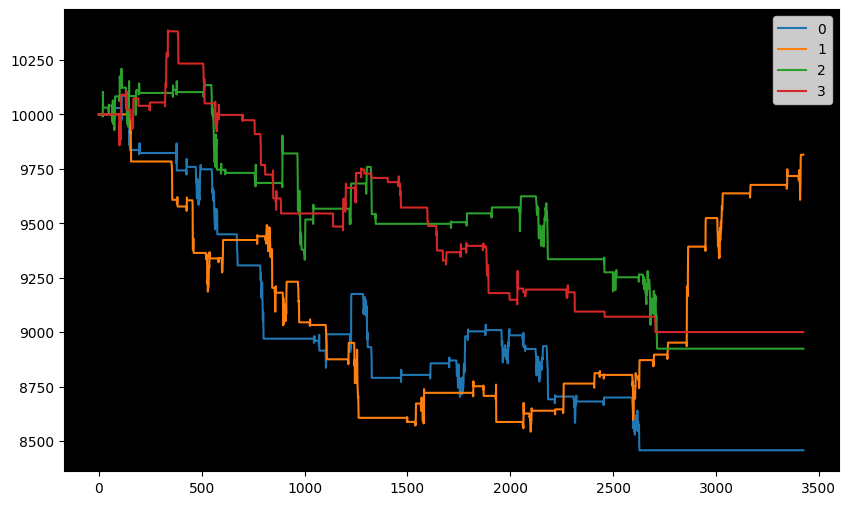

In [29]:
import matplotlib.pyplot as plt

equity_df.plot(kind='line', figsize=(10, 6), legend=True).set_facecolor('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')
plt.gca().set_facecolor('black')